In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import IPython as ip

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import yacht_main as yacht

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
torch.cuda.is_available()

True

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
INPUT_SIZE = 43
OUTPUT_SIZE = 43

class DQN(nn.Module):

    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 50)
        #self.fc4 = nn.Linear(100, 100)
        #self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(50, output_size)
        
        self.LR = nn.LeakyReLU()
        
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        #x = F.relu(self.fc4(x))
        #x = F.relu(self.fc5(x))

        x = self.fc6(x)

        return x

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.constant_(m,0.1)


policy_net = DQN(INPUT_SIZE,OUTPUT_SIZE).to(device)
target_net = DQN(INPUT_SIZE,OUTPUT_SIZE).to(device)
#W = torch.tensor((43,1), device = device, dtype = torch.float)

init_weights(policy_net)
target_net.load_state_dict(policy_net.state_dict())
#init_weights(W)
#policy_net.apply(init_weights)
#target_net.apply(init_weights)

<All keys matched successfully>

In [4]:
BATCH_SIZE = 128
MEMORY_SIZE = 3000
GAMMA = 0.2
EPS_START = 0.9
EPS_END = 0.02
EPS_DECAY = 800
TARGET_UPDATE = 10
ALPHA = 0.1
REWARD_SCALE = 1.0/50

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(MEMORY_SIZE)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(OUTPUT_SIZE)]], device=device, dtype=torch.long)



episode_scores = []


def plot_scores():
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(scores_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(scores_t) >= 50:
        means = scores_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())

    ip.display.clear_output(wait=True)
    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    #if is_ipython:
    #display(plt.gcf())

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch
    batch = Transition(*zip(*transitions))
    """
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                      batch.next_state)), dtype=torch.bool)
    temp = [s for s in batch.next_state if s is not None]
    if len(temp) == 0:
        return
 
    
    non_final_next_states = torch.cat(temp)
    """
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    
    
    """
    state_action_values = policy_net(state_batch)

    next_state_values = torch.zeros((BATCH_SIZE, OUTPUT_SIZE), device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states)
    # 기대 Q 값 계산
    #expected_state_action_values = ((next_state_values * GAMMA) + reward_batch)*ALPHA + state_action_values*(1-ALPHA)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch*REWARD_SCALE
    # Huber 손실 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    """
    """
    Qpred = policy_net(state_batch).gather(1, action_batch)
    #Qpred = torch.index_select(policy_net(state_batch), dim = 1, index = torch.argmax(action_batch, dim = 1))
    
    next_state_values = torch.zeros((BATCH_SIZE,1), device=device, dtype = torch.float)
    next_state_values[non_final_mask] = torch.max(target_net(non_final_next_states), dim=1)[0].reshape(len(non_final_next_states),1 )

    Qs = next_state_values * GAMMA + reward_batch * REWARD_SCALE
    """
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device) * -100
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch * REWARD_SCALE
    
    """
    Qs = torch.zeros(BATCH_SIZE, device=device, dtype = torch.float, requires_grad = True)
    
    for i in range(BATCH_SIZE):
        if next_state_batch[i] is not None:
            Qs[i] += torch.argmax(target_net(next_states[i])) * GAMMA
    Qs += reward_batch * REWARD_SCALE
    """
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optimizer.step()

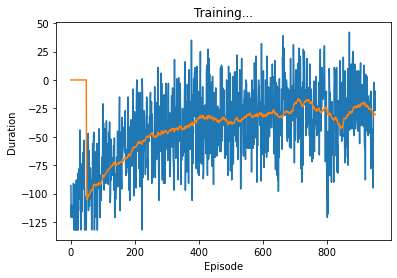

KeyboardInterrupt: 

In [6]:
num_episodes = 500000
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    yacht.reset_game()
    state, reward, _ = yacht.get_yacht_output()
    state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
    for t in count():
        # 행동 선택과 수행
        action = select_action(state.reshape(1,INPUT_SIZE))
        yacht.update(action)
        new_state, new_reward, done = yacht.get_yacht_output()
        step_reward = torch.tensor([new_reward - reward], device=device, requires_grad = False)

        if not done:
            new_state = torch.tensor(new_state, dtype=torch.float, device=device, requires_grad = False)
            memory.push(state.reshape(1,INPUT_SIZE), action, new_state.reshape(1,INPUT_SIZE), \
                    step_reward)
        else:
            new_state = None
            memory.push(state.reshape(1,INPUT_SIZE), action, None, \
                    step_reward)
        

        # 다음 상태로 이동
        state = new_state
        reward = new_reward

        # 최적화 한단계 수행(목표 네트워크에서)
        optimize_model()
        if done:
            state, score, _ = yacht.get_yacht_output()
            episode_scores.append(score)
            #print("{0}) {1}\tscore : {2}, turns = {3}".format(i_episode, state[:12], score, t+1))
            
            print(str(state[:12]))
            
            plot_scores()
            
            break
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode % 10000 == 0:
        torch.save(policy_net.state_dict(), './data/solo_net_' + str(i_episode//10000))

print('Complete')

In [ ]:
def step_by_step():
    yacht.reset_game()
    
    state, _, _ = yacht.get_yacht_output()
    print("{0}\tscore : {1}, turns = {2}".format(state, 0, 0))
    state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
    
    for t in count():
#        policy_net(state).max(1)[1].view(1, 1)
        action = select_action(state.reshape(1,INPUT_SIZE))
        print("\nActions: {0}".format(action[0][0] ))
        yacht.update(action)
        
        state, score, done = yacht.get_yacht_output()
        print("{0}\tscore : {1}, turns = {2}".format(state, score, t+1))
        state = torch.tensor(state, dtype=torch.float, device=device, requires_grad = False)
        
        if done:
            break
step_by_step()

In [ ]:
def print_memory(mem):
    print("\n\nState: {0}".format(mem.state[0].int().tolist() ))
    print("Action: {0}".format(action[0][0] ))
    if mem.next_state == None:
        print("State: None")
    else:
        print("State: {0}".format(mem.next_state[0].int().tolist() ))
    print("Reward: {0}".format(mem.reward[0][0].int() ))
    

In [ ]:
for i in range(10):
    print_memory(memory.memory[i])

In [ ]:
[[-1]*12]*2

In [ ]:
test_net = DQN(INPUT_SIZE, OUTPUT_SIZE)
test_net.load_state_dict(torch.load('./data/solo_net_1'))
test_net.eval()

In [ ]:
yacht.reset_game()

In [ ]:
state,_,_ = yacht.get_yacht_output()
print(state)
action = test_net(torch.tensor(state, dtype=torch.float).reshape(1,INPUT_SIZE)).max(1)[1]
yacht.update(action)
print(action-30)

In [ ]:
device